# lasso

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas_datareader import data
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [1]:
def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

In [2]:
def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

In [3]:
def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

In [4]:
def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

In [7]:
goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2021-01-01',
    output_file='goog_data_large.pkl')

File data found...reading GOOG data


In [8]:
goog_data, X, Y = create_regression_trading_condition(goog_data)
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

In [9]:
# Fit the model
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)

# The coefficients
print('Coefficients: \n', lasso.coef_)

Coefficients: 
 [ 0.01681235 -0.04842963]


In [10]:
goog_data['Predicted_Signal'] = lasso.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))

print(goog_data.head())

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2004-08-19  51.835709  47.800831  49.813290  49.982655  44871361.0  49.982655   
2004-08-20  54.336334  50.062355  50.316402  53.952770  22942874.0  53.952770   
2004-08-23  56.528118  54.321388  55.168217  54.495735  18342897.0  54.495735   
2004-08-24  55.591629  51.591621  55.412300  52.239197  15319808.0  52.239197   
2004-08-25  53.798351  51.746044  52.284027  52.802086   9232276.0  52.802086   

            Open-Close  High-Low    Target  Predicted_Signal  GOOG_Returns  
Date                                                                        
2004-08-19   -0.169365  4.034878  3.970116          0.266100           NaN  
2004-08-20   -3.636368  4.273979  0.542965          0.196232      0.076433  
2004-08-23    0.672482  2.206730 -2.256538          0.368790      0.010013  
2004-08-24    3.173103  4.000008  0.562889     

In [11]:
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

In [12]:
def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

In [13]:
cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')

In [14]:
def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

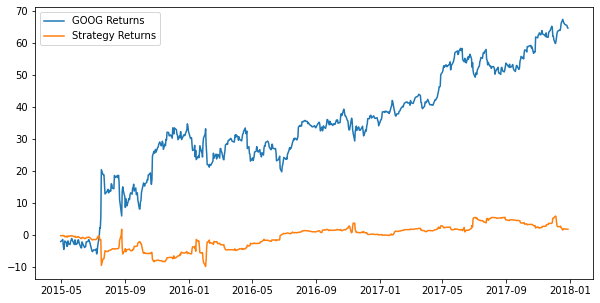

In [15]:
plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')

In [16]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

In [17]:
print(sharpe_ratio(cum_strategy_return, cum_goog_return))

1.9722800881476563


In [18]:
# 평균제곱오차 1에 가까울수록 적합
print("Mean squared error: %.2f"
      % mean_squared_error(Y_train, lasso.predict(X_train)))
# 설명된 분산 점수: 1이면 완벽한 예측이다.
print('Variance score: %.2f' % r2_score(Y_train, lasso.predict(X_train)))

# 평균제곱오차
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, lasso.predict(X_test)))
# 설명된 분산 점수: 1이면 완벽한 예측이다.
print('Variance score: %.2f' % r2_score(Y_test, lasso.predict(X_test)))

Mean squared error: 27.52
Variance score: 0.00
Mean squared error: 103.38
Variance score: -0.01
